# Converting common burnysc2 and python functions to cython

In [1]:
# Change path as needed
MAP_PATH = "../tests/combat_data/GresvanAIE.xz"

In [2]:
# load cell magic things
%load_ext line_profiler
%load_ext Cython

In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from sc2.ids.unit_typeid import UnitTypeId
from sc2.bot_ai import BotAI
from sc2.position import Point2
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.data import Race
from sc2.unit import Unit
from sc2.units import Units

from tests.load_bot_from_pickle import get_map_specific_bot

In [4]:
DOES_NOT_USE_LARVA: dict[UnitTypeId, UnitTypeId] = {
    UnitTypeId.BANELING: UnitTypeId.ZERGLING,
    UnitTypeId.BROODLORD: UnitTypeId.CORRUPTOR,
    UnitTypeId.LURKERMP: UnitTypeId.HYDRALISK,
    UnitTypeId.OVERSEER: UnitTypeId.OVERLORD,
    UnitTypeId.OVERLORDTRANSPORT: UnitTypeId.OVERLORD,
    UnitTypeId.RAVAGER: UnitTypeId.ROACH,
}

In [5]:
# setup a burnysc2 BOTAI instance we can test with
bot: BotAI = get_map_specific_bot(MAP_PATH)

# some variables we use throughout the notebook
grid: np.ndarray = bot.game_info.pathing_grid.data_numpy.T
# converting the type here, as matches that used in MapAnalyzer
grid = grid.astype(np.float32, copy=False)
position = bot.enemy_start_locations[0]
units = bot.all_units

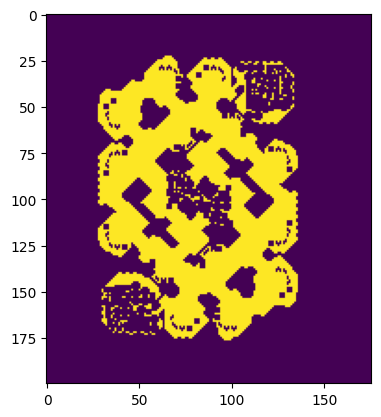

In [6]:
# sanity check that the bot instance is working
plt.imshow(grid)

# Contents

* [Converting is_position_safe](#Cython-version-of-is_position_safe) **6.57x speedup**
* [Alternative to python-sc2's units.closest_to](#Alternative-to-python-sc2's-units.closest_to) **6.85x speedup**
* [Speeding up `Units.center`](#Speeding-up-Units.center) **2.01x speedup**
* [Distance to / `unit.distance_to`](#Distance-to-/-unit.distance_to) **3 to 7x speedup depending on scenario**
* [Convert `already_pending` for units](#Optimize-already_pending) **6.62x speedup**
* [Alternative to `python-sc2`'s `units.in_attack_range`](#Alternative-to-python-sc2's-units.in_attack_range) **2.05x speedup**
* [Calculate if attack is ready](#Calculate-if-attack-is-ready) **3.87x speedup**
* [Pick enemy target](#Pick-enemy-target) **1.63x speedup**
* [Converting `units.sorted_by_distance_to`](#Converting-units.sorted_by_distance_to) **8.622x speedup**
* [Convert `unit.is_facing()`](#Convert-unit.is_facing()) **9.1x speedup**
* [Convert `Point2.towards()`](#Convert-Point2.towards()) **14.29x speedup**

## Cython version of `is_position_safe`

This is a handy method when combined with MapAnalyzer's pathing and influence system, but we are not using MapAnalyzer in this project so could potentially be reused
with any numpy enemy influence grid.

In [7]:
def is_position_safe(
    grid: np.ndarray,
    position: Point2,
    weight_safety_limit: float = 1.0,
) -> bool:
    weight: float = grid[position.rounded]
    # np.inf check if drone is pathing near a spore crawler
    return weight == np.inf or weight <= weight_safety_limit

In [8]:
%timeit is_position_safe(grid, position)

539 ns ± 7.65 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [13]:
%%cython
import numpy as np
cimport numpy as cnp
from cython cimport boundscheck, wraparound
from libc.math cimport floor
@boundscheck(False)
@wraparound(False)
cpdef bint is_position_safe(
    cnp.ndarray[cnp.npy_float32, ndim=2] grid,
    (double, double) position,
    double weight_safety_limit = 1.0
):
    cdef double weight = 0.0
    cdef unsigned int x = <unsigned int>floor(position[0])
    cdef unsigned int y = <unsigned int>floor(position[1])

    weight = grid[x, y]
    # np.inf check if drone is pathing near a spore crawler
    return weight == np.inf or weight <= weight_safety_limit

Content of stderr:
/home/tom/.cache/ipython/cython/_cython_magic_62a7d0dc8863449be20d658b1d1adf765080b3a2f6b58c9384214932a71b7b88.c: In function ‘__pyx_pw_78_cython_magic_62a7d0dc8863449be20d658b1d1adf765080b3a2f6b58c9384214932a71b7b88_1is_position_safe’:
/home/tom/.cache/ipython/cython/_cython_magic_62a7d0dc8863449be20d658b1d1adf765080b3a2f6b58c9384214932a71b7b88.c:4791:30: warning: ‘result.f1’ may be used uninitialized in this function [-Wmaybe-uninitialized]
 4791 |   __pyx_v_y = ((unsigned int)floor(__pyx_v_position.f1));
      |                              ^~~~~~~~~~~~~~~~~~~~~~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_62a7d0dc8863449be20d658b1d1adf765080b3a2f6b58c9384214932a71b7b88.c:10049:37: note: ‘result.f1’ was declared here
10049 |     __pyx_ctuple_double__and_double result;
      |                                     ^~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_62a7d0dc8863449be20d658b1d1adf765080b3a2f6b58c9384214932a71b7b88.c:4782:30: warning: ‘result.f0’

In [18]:
%timeit is_position_safe(grid, position)

306 ns ± 4.61 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [15]:
%timeit is_position_safe(grid, position)

259 ns ± 2.08 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# Alternative to `python-sc2`'s `units.closest_to`

In [11]:
unit = units[0]

In [12]:
# slower using closest_to(Point2)
%timeit units.closest_to(position)

216 µs ± 753 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# this is faster since distance between all units is cached
%timeit units.closest_to(unit)

111 µs ± 896 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%%cython
from cython cimport boundscheck, wraparound

cdef double euclidean_distance_squared(
        (float, float) p1,
        (float, float) p2
):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

@boundscheck(False)
@wraparound(False)
cpdef object cy_closest_to((float, float) position, object units):
    cdef:
        object closest = units[0]
        double closest_dist = 999.9
        double dist = 0.0
        Py_ssize_t len_units = len(units)
        (float, float) pos
        
    for i in range(len_units):
        unit = units[i]
        pos = unit.position
        dist = euclidean_distance_squared((pos[0], pos[1]), (position[0], position[1]))
        if dist < closest_dist:
            closest_dist = dist
            closest = unit
            
    return closest

Content of stdout:
_cython_magic_ef007275fee20e44970d245f5d809e62a6db9847.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_ef007275fee20e44970d245f5d809e62a6db9847.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_ef007275fee20e44970d245f5d809e62a6db9847.cp311-win_amd64.exp
Generating code
Finished generating code

In [15]:
%timeit cy_closest_to(position, units)

16.2 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Check we are getting the same result as the original burnysc2 version

In [16]:
assert units.closest_to(unit) == cy_closest_to(unit.position, units)
assert units.closest_to(position) == cy_closest_to(position, units)

# Speeding up `Units.center`

Similar to units.center in python-sc2, but tweaked to work in this notebook

In [7]:
def center(units) -> Point2:
    """Returns the central position of all units."""
    assert units, f"Units object is empty"
    amount = units.amount
    return Point2(
        (
            sum(unit._proto.pos.x for unit in units) / amount,
            sum(unit._proto.pos.y for unit in units) / amount,
        )
    )

In [8]:
%timeit center(units)

659 µs ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%cython

cimport cython
from sc2.position import Point2

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef (double, double) cy_center(object units):
    """Returns the central position of all units."""
    cdef:
        unsigned int i = 0
        double MAX_THRESHOLD = 600.0
        Py_ssize_t num_units = len(units)
        double sum_x, sum_y, x, y
        (double, double) position
        object unit

    sum_x = 0
    sum_y = 0

    for i in range(num_units):
        pos = units[i].position
        position = (pos.x, pos.y)
        sum_x += position[0]
        sum_y += position[1]
    x = sum_x / num_units
    y = sum_y / num_units
    if x > MAX_THRESHOLD or y > MAX_THRESHOLD:
        return position   
    return (x, y)

In [22]:
%timeit Point2(cy_center(units))

252 µs ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
assert Point2(cy_center(units)) == center(units)

# Distance to / `unit.distance_to`
Check and profile distances between 2 units / 1 unit and a Point2 / two Point2's using python-sc2 implementation of distance_to.

Then see if cython does it faster

In [7]:
unit1 = bot.workers[0]
unit2 = bot.workers[4]
position1 = bot.game_info.map_center
position2 = bot.enemy_start_locations[0]

In [8]:
%timeit unit1.distance_to(unit2)

616 ns ± 11.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%timeit unit1.distance_to(position1)

1.04 µs ± 20.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
%timeit position1.distance_to(position2)

377 ns ± 1.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [11]:
%%cython

cpdef double cy_distance_to(
        (double, double) p1,
        (double, double) p2
):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

Content of stdout:
_cython_magic_c53e4b086c432ad6bb9f31358a07efe9ad536520.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_c53e4b086c432ad6bb9f31358a07efe9ad536520.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_c53e4b086c432ad6bb9f31358a07efe9ad536520.cp311-win_amd64.exp
Generating code
Finished generating code

In [12]:
%timeit cy_distance_to(unit1.position, unit2.position)

218 ns ± 2.17 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [13]:
%timeit cy_distance_to(unit1.position, position1)

191 ns ± 3.43 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [14]:
%timeit cy_distance_to(position1, position2)

175 ns ± 0.736 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [15]:
assert unit1.distance_to(unit2) == cy_distance_to(unit1.position, unit2.position)
assert unit1.distance_to(position1) == cy_distance_to(unit1.position, position1)
assert position1.distance_to(position2) == cy_distance_to(position1, position2)

<b>Performance gains using distance squared</b>

In [20]:
%%cython

cpdef double cy_distance_to_squared(
        (double, double) p1,
        (double, double) p2
):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

Content of stdout:
_cython_magic_a4550c7049a95047f84ba8c3cb3f25bc6ffd8273.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_a4550c7049a95047f84ba8c3cb3f25bc6ffd8273.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_a4550c7049a95047f84ba8c3cb3f25bc6ffd8273.cp311-win_amd64.exp
Generating code
Finished generating code

In [21]:
%timeit cy_distance_to_squared(unit1.position, unit2.position)

176 ns ± 0.768 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [22]:
%timeit cy_distance_to_squared(unit1.position, position1)

147 ns ± 0.877 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [23]:
%timeit cy_distance_to_squared(position1, position2)

133 ns ± 0.631 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Summary
Almost 7x speedup in worsecase scenario vs burnysc2's `unit.distance_to(position)`!

Even where burnysc2 performs well `unit.distance_to(other_unit)`, we get a 3x speedup

# Optimize `already_pending`

When profiling burnysc2 bots, `already_pending` often stands out as being slow. It's useful however in that it works for both structures and units. So to create an alternative
we will need to create seperate functions for `unit_pending` and `structure_pending`


## Custom `unit_pending` python function

Let's try a typical scenario, checking if a marine is pending

In [31]:
# in burnysc2:
%timeit bot.already_pending(UnitTypeId.MARINE)

2.53 µs ± 13.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [32]:
def unit_pending(unit_type: UnitTypeId) -> int:
    trained_from = UNIT_TRAINED_FROM[unit_type]
    if bot.race != Race.Zerg or unit_type == UnitTypeId.QUEEN:
        return len(
            [
                s
                for s in bot.structures
                if s.orders and s.type_id in trained_from
                and s.orders[0].ability.button_name.upper() == UnitTypeId.MARINE.name
            ]
        )
    # check eggs and cocoons for Zerg
    else:
        if type_id in DOES_NOT_USE_LARVA:
            if type_id == UnitTypeId.LURKERMP:
                return len(bot.own_units(UnitTypeId.LURKERMPEGG))
            elif type_id == UnitTypeId.OVERSEER:
                return len(bot.own_units(UnitTypeId.OVERLORDCOCOON))
            return len(bot.own_units(UnitTypeId[f"{type_id.name}COCOON"]))
        else:
            return len(
                [
                    egg
                    for egg in self.eggs
                    if egg.orders[0].ability.button_name.upper() == type_id.name
                ]
            )

In [33]:
%timeit unit_pending(UnitTypeId.MARINE)

1.19 µs ± 5.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


<b> Python version already 2x faster! Convert to cython</b>

In [34]:
%%cython

from sc2.ids.unit_typeid import UnitTypeId
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.game_info import Race

DOES_NOT_USE_LARVA: dict[UnitTypeId, UnitTypeId] = {
    UnitTypeId.BANELING: UnitTypeId.ZERGLING,
    UnitTypeId.BROODLORD: UnitTypeId.CORRUPTOR,
    UnitTypeId.LURKERMP: UnitTypeId.HYDRALISK,
    UnitTypeId.OVERSEER: UnitTypeId.OVERLORD,
    UnitTypeId.OVERLORDTRANSPORT: UnitTypeId.OVERLORD,
    UnitTypeId.RAVAGER: UnitTypeId.ROACH,
}

cimport cython

cpdef unsigned int cy_unit_pending(object unit_type, object bot):
    cdef:
        Py_ssize_t num_pending = 0
        Py_ssize_t len_units, x
        set trained_from = UNIT_TRAINED_FROM[unit_type]
        object units_collection, unit

    if bot.race == Race.Zerg and unit_type != UnitTypeId.QUEEN:
        if unit_type in DOES_NOT_USE_LARVA:
            units_collection = bot.own_units
            len_units = len(bot.own_units)
            trained_from = {UnitTypeId[f"{unit_type.name}COCOON"]}
            if unit_type == UnitTypeId.LURKERMP:
                trained_from = {UnitTypeId.LURKERMPEGG}
            elif unit_type == UnitTypeId.OVERSEER:
                trained_from = {UnitTypeId.OVERLORDCOCOON}
            
            for x in range(len_units):
                unit = units_collection[x]
                if unit.type_id in trained_from:
                    num_pending += 1
            return num_pending
        # unit will be pending in eggs
        else:
            units_collection = bot.eggs
            len_units = len(units_collection)
            for x in range(len_units):
                egg = units_collection[x]
                if egg.orders and egg.orders[0].ability.button_name.upper() == unit_type.name:
                    num_pending += 1
            return num_pending

    # all other units, check the structures they are built from
    else:
        units_collection = bot.structures
        len_units = len(units_collection)
        for x in range(len_units):
            structure = units_collection[x]
            if structure.orders and structure.orders[0].ability.button_name.upper() == unit_type.name:
                num_pending += 1
        return num_pending

Content of stdout:
_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.c
C:\Users\Tom\.ipython\cython\_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.c(2859): warning C4244: '=': conversion from 'Py_ssize_t' to 'unsigned int', possible loss of data
C:\Users\Tom\.ipython\cython\_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.c(3007): warning C4244: '=': conversion from 'Py_ssize_t' to 'unsigned int', possible loss of data
C:\Users\Tom\.ipython\cython\_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.c(3153): warning C4244: '=': conversion from 'Py_ssize_t' to 'unsigned int', possible loss of data
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_065d3597ba73c0d5076cfacca815598f313500a6.cp311-win_amd64.exp
Generating code
Finished generating code

In [35]:
%timeit cy_unit_pending(UnitTypeId.MARINE, bot)

424 ns ± 1.95 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Cython version 6-7 times faster with a warning that this doesn't factor in warp ins

Something similar could be done for structures, `cy_structure_pending` for example. But this depends on the bot
<br>
`ares-sc2` has a building tracker for example so this makes it easy to check what is pending even if a worker does not have a build action yet. Add this to structures pending without a worker (zerg and protoss)

Something similar could be done for upgrades too.

# Alternative to `python-sc2`'s `units.in_attack_range`

In [9]:
_units = Units([u for u in units if not u.is_mineral_field and not u.is_vespene_geyser and u not in bot.destructables], bot)
unit = _units[-6]

In [10]:
%timeit _units.in_attack_range_of(unit)

156 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%%cython
import cython
from cython_extensions.unit_data import UNIT_DATA

UNIT_DATA_INT_KEYS = {k.value: v for k, v in UNIT_DATA.items()}

cdef double cy_distance_to(
        (float, float) p1,
        (float, float) p2
):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef list cy_in_attack_range(object unit, object units, double bonus_distance = 0.0):
    if not unit.can_attack:
        return []

    cdef:
        unsigned int x, len_units, type_id_int
        double dist, air_range, ground_range, radius, other_u_radius
        (float, float) unit_pos, other_unit_pos
        bint other_unit_flying, can_shoot_air, can_shoot_ground

    can_shoot_air = unit.can_attack_air
    can_shoot_ground = unit.can_attack_ground
    len_units = len(units)
    returned_units = []
    unit_pos = unit.position
    radius = unit.radius
    air_range = unit.air_range
    ground_range = unit.ground_range

    for x in range(len_units):
        u = units[x]
        type_id_int = unit._proto.unit_type
        unit_data = UNIT_DATA_INT_KEYS.get(type_id_int, None)
        if unit_data:
            other_unit_flying = unit_data["flying"]
            other_unit_pos = u.position
            other_u_radius = u.radius
            dist = cy_distance_to(unit_pos, other_unit_pos)
    
            if can_shoot_air and (other_unit_flying or type_id_int == 4):
                if dist <= air_range + radius + other_u_radius + bonus_distance:
                    returned_units.append(u)
                    # already added, no need to attempt logic below
                    continue
    
            if can_shoot_ground and not other_unit_flying:
                if dist <= ground_range + radius + other_u_radius + bonus_distance:
                    returned_units.append(u)

    return returned_units      

In [14]:
%timeit cy_in_attack_range(unit, _units)

76.3 ns ± 0.196 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [40]:
assert _units.in_attack_range_of(unit) == cy_in_attack_range(unit, _units)

In [41]:
print(_units.in_attack_range_of(unit))
print(cy_in_attack_range(unit, _units))

[Unit(name='CommandCenter', tag=4351328257), Unit(name='SCV', tag=4353163265)]
[Unit(name='CommandCenter', tag=4351328257), Unit(name='SCV', tag=4353163265)]


# Calculate if attack is ready
This is not a alternative to anything in burnysc2, the closest thing would be `unit.weapon_cooldown == 0` or something.


But is useful for checking if weapon is ready, taking into account turn rate, turn speed, unit speed, weapon range and distance to target

## Initial python version

In [42]:
from cython_extensions.turn_rate import TURN_RATE
import math

def angle_to(from_pos: Point2, to_pos: Point2) -> float:
    """Angle from point to other point in radians"""
    return math.atan2(to_pos.y - from_pos.y, to_pos.x - to_pos.x)

def angle_diff(a, b) -> float:
    """Absolute angle difference between 2 angles"""
    if a < 0:
        a += math.pi * 2
    if b < 0:
        b += math.pi * 2
    return math.fabs(a - b)

def get_turn_speed(unit) -> float:
    """Returns turn speed of unit in radians"""
    if unit.type_id in TURN_RATE:
        return TURN_RATE[unit.type_id] * 1.4 * math.pi / 180

def range_vs_target(unit, target) -> float:
    """Get the range of a unit to a target."""
    if unit.can_attack_air and target.is_flying:
        return unit.air_range
    else:
        return unit.ground_range

def attack_ready(bot, unit: Unit, target: Unit) -> bool:
    """
    Determine whether the unit can attack the target by the time the unit faces the target.
    """
    # fix for units, where this method returns False so the unit moves
    # but the attack animation is still active, so the move command cancels the attack
    # need to think of a better fix later, but this is better then a unit not attacking
    # and still better then using simple weapon.cooldown == 0 micro
    type_id = unit.type_id
    if unit.weapon_cooldown > 7 and type_id == UnitID.HYDRALISK:
        return True
    # prevents crash, since unit can't move
    if type_id == UnitTypeId.LURKERMPBURROWED:
        return True
    if not unit.can_attack:
        return False
    # Time elapsed per game step
    step_time: float = bot.client.game_step / 22.4

    # Time it will take for unit to turn to face target
    angle: float = angle_diff(
        unit.facing, angle_to(unit.position, target.position)
    )
    turn_time: float = angle / get_turn_speed(unit)

    # Time it will take for unit to move in range of target
    distance = (
        unit.position.distance_to(target)
        - unit.radius
        - target.radius
        - range_vs_target(unit, target)
    )
    distance = max(0, distance)
    move_time = distance / ((unit.real_speed + 1e-16) * 1.4)

    return step_time + turn_time + move_time >= unit.weapon_cooldown / 22.4

In [43]:
_units = Units([u for u in units if not u.is_mineral_field and not u.is_vespene_geyser and u not in bot.destructables], bot)
unit = _units[-6]
target = units.in_attack_range_of(unit)[0]

In [44]:
attack_ready(bot, unit, target)
%timeit attack_ready(bot, unit, target)

5.45 µs ± 59.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Find the bottlenecks

In [45]:
%lprun -f attack_ready attack_ready(bot, unit, target)

Timer unit: 1e-07 s

Total time: 9.19e-05 s
File: C:\Users\Tom\AppData\Local\Temp\ipykernel_21212\2261925512.py
Function: attack_ready at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                           def attack_ready(bot, unit: Unit, target: Unit) -> bool:
    29                                               """
    30                                               Determine whether the unit can attack the target by the time the unit faces the target.
    31                                               """
    32                                               # fix for units, where this method returns False so the unit moves
    33                                               # but the attack animation is still active, so the move command cancels the attack
    34                                               # need to think of a better fix later, but this is better then a unit not attacking
    35                              

In [46]:
%%cython

from sc2.ids.unit_typeid import UnitTypeId as UnitID
from sc2.unit import Unit
from cython_extensions.turn_rate import TURN_RATE
from cython_extensions.unit_data import UNIT_DATA
UNIT_DATA_INT_KEYS = {k.value: v for k, v in UNIT_DATA.items()}
TURN_RATE_INT_KEYS = {k.value: v for k, v in TURN_RATE.items()}
import math
from libc.math cimport atan2, fabs, pi

cdef double cy_distance_to(
        (float, float) p1,
        (float, float) p2
):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

cdef double angle_to((float, float) from_pos, (float, float) to_pos):
    """Angle from point to other point in radians"""
    return atan2(to_pos[1] - from_pos[1], to_pos[0] - to_pos[0])

cdef double angle_diff(double a, double b):
    """Absolute angle difference between 2 angles"""
    if a < 0:
        a += pi * 2
    if b < 0:
        b += pi * 2
    return fabs(a - b)

cdef double get_turn_speed(unit, unsigned int unit_type_int):
    """Returns turn speed of unit in radians"""
    cdef double turn_rate

    turn_rate = TURN_RATE_INT_KEYS.get(unit_type_int, None)
    if turn_rate:
        return turn_rate * 1.4 * pi / 180

cdef double range_vs_target(unit, target):
    """Get the range of a unit to a target."""
    if unit.can_attack_air and target.is_flying:
        return unit.air_range
    else:
        return unit.ground_range

cpdef bint cy_attack_ready(bot, unit, target):
    """
    Determine whether the unit can attack the target by the time the unit faces the target.
    Thanks Sasha for writing this out.
    """
    cdef:
        unsigned int unit_type_int = unit._proto.unit_type
        unsigned int weapon_cooldown
        double angle, distance, move_time, step_time, turn_time, unit_speed
        (float, float) unit_pos
        (float, float) target_pos

    # fix for units, where this method returns False so the unit moves
    # but the attack animation is still active, so the move command cancels the attack
    # need to think of a better fix later, but this is better then a unit not attacking
    # and still better then using simple weapon.cooldown == 0 micro
    weapon_cooldown = unit.weapon_cooldown
    if weapon_cooldown > 7 and unit_type_int == 91:  # 91 == UnitID.HYDRALISK
        return True
    # prevents crash, since unit can't move
    if unit_type_int == 91:  # == UnitID.LURKERMPBURROWED
        return True
    if not unit.can_attack:
        return False
    # Time elapsed per game step
    step_time = bot.client.game_step / 22.4

    unit_pos = unit.position
    target_pos = target.position
    # Time it will take for unit to turn to face target
    angle = angle_diff(
        unit.facing, angle_to(unit_pos, target_pos)
    )
    turn_time = angle / get_turn_speed(unit, unit_type_int)

    # Time it will take for unit to move in range of target
    distance = (
        cy_distance_to(unit_pos, target_pos)
        - unit.radius
        - target.radius
        - range_vs_target(unit, target)
    )
    distance = max(0, distance)
    unit_speed = (unit.real_speed + 1e-16) * 1.4
    move_time = distance / unit_speed

    return step_time + turn_time + move_time >= weapon_cooldown / 22.4

Content of stdout:
_cython_magic_68ad02ee9d9653ecd6ead60fb1a59b7833db4a9f.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_68ad02ee9d9653ecd6ead60fb1a59b7833db4a9f.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_68ad02ee9d9653ecd6ead60fb1a59b7833db4a9f.cp311-win_amd64.exp
Generating code
Finished generating code

In [47]:
%timeit cy_attack_ready(bot, unit, target)

1.47 µs ± 11.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [48]:
assert cy_attack_ready(bot, unit, target) == attack_ready(bot, unit, target)

# Pick enemy target

In [49]:
def pick_enemy_target(enemies: Units) -> Unit:
    """For best enemy target from the provided enemies
    TODO: If there are multiple units that can be killed, pick the highest value one
        Unit parameter to allow for this in the future

    For now this returns the lowest health enemy
    """
    return min(
        enemies,
        key=lambda e: (e.health + e.shield, e.tag),
    )

In [50]:
pick_enemy_target(units).health

0.0

In [51]:
%timeit pick_enemy_target(units)

144 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [52]:
%%cython

cpdef object cy_pick_enemy_target(enemies):
    """For best enemy target from the provided enemies
    TODO: If there are multiple units that can be killed, pick the highest value one
        Unit parameter to allow for this in the future

    For now this returns the lowest health enemy
    """
    cdef:
        object returned_unit
        Py_ssize_t num_enemies
        unsigned int x
        double lowest_health, total_health
    
    num_enemies = len(enemies)
    returned_unit = enemies[0]
    lowest_health = 999.9
    for x in range(num_enemies):
        unit = enemies[x]
        total_health = unit.health + unit.shield
        if total_health < lowest_health:
            lowest_health = total_health
            returned_unit = unit

    return returned_unit

Content of stdout:
_cython_magic_4995851fb468f0ee0820c27ab81ace5b63686d77.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_4995851fb468f0ee0820c27ab81ace5b63686d77.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_4995851fb468f0ee0820c27ab81ace5b63686d77.cp311-win_amd64.exp
Generating code
Finished generating code

In [53]:
%timeit cy_pick_enemy_target(units)

75.9 µs ± 408 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
cy_pick_enemy_target(units).health

0.0

In [55]:
assert cy_pick_enemy_target(units) == pick_enemy_target(units)

# Converting `units.sorted_by_distance_to`

In [15]:
position = bot.enemy_start_locations[0]

In [16]:
%timeit units.sorted_by_distance_to(position)

1.69 ms ± 9.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
units.sorted_by_distance_to(position)[:12]

[Unit(name='FlyoverUnit', tag=4495507457),
 Unit(name='SeekerMissile', tag=4541120513),
 Unit(name='Interceptor', tag=4510711809),
 Unit(name='CorsairMP', tag=4481089537),
 Unit(name='LocustMPFlying', tag=4481351681),
 Unit(name='ScourgeMP', tag=4482138113),
 Unit(name='BypassArmorDrone', tag=4482924545),
 Unit(name='PointDefenseDrone', tag=4484497409),
 Unit(name='VoidRay', tag=4482662401),
 Unit(name='Oracle', tag=4485021697),
 Unit(name='GuardianCocoonMP', tag=4491313153),
 Unit(name='Larva', tag=4497342465)]

In [18]:
%%cython

import numpy as np
cimport numpy as cnp

cdef double cy_distance_to_squared(
        (float, float) p1,
        (float, float) p2
):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

cpdef object cy_sorted_by_distance_to(object units, (float, float) position, bint reverse=False):
    cdef:
        Py_ssize_t len_units = len(units)
        cnp.ndarray[cnp.npy_double, ndim=1] distances = np.empty(len_units)
        # couldn't get this to work
        # cnp.ndarray[cnp.npy_double, ndim=1] indices = np.empty(len_units)
        unsigned int i, j
 
    for i in range(len_units):
        distances[i] = cy_distance_to_squared(units[i].position, position)

    indices = distances.argsort()

    return [units[j] for j in indices]

In [19]:
cy_sorted_by_distance_to(units, position)[:12]

[Unit(name='CorsairMP', tag=4481089537),
 Unit(name='FlyoverUnit', tag=4495507457),
 Unit(name='Interceptor', tag=4510711809),
 Unit(name='SeekerMissile', tag=4541120513),
 Unit(name='LocustMPFlying', tag=4481351681),
 Unit(name='ScourgeMP', tag=4482138113),
 Unit(name='BypassArmorDrone', tag=4482924545),
 Unit(name='PointDefenseDrone', tag=4484497409),
 Unit(name='VoidRay', tag=4482662401),
 Unit(name='Oracle', tag=4485021697),
 Unit(name='GuardianCocoonMP', tag=4491313153),
 Unit(name='Larva', tag=4497342465)]

In [20]:
%timeit cy_sorted_by_distance_to(units, position)

196 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Convert `unit.is_facing()`

In [12]:
my_unit = bot.workers[0]
other_unit = bot.townhalls[0]

In [13]:
%timeit my_unit.is_facing(other_unit)

3.23 µs ± 30.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
my_unit.is_facing(other_unit)

False

In [19]:
%%cython

from libc.math cimport atan2, fabs, pi
import numpy as np


cpdef bint cy_is_facing(unit, other_unit, double angle_error=0.05):
    cdef:
        (double, double) p1 = unit.position
        (double, double) p2 = other_unit.position
        double angle, angle_difference
        double unit_facing = unit.facing

    angle = atan2(
        p2[1] - p1[1],
        p2[0] - p1[0],
    )
    print(angle)
    if angle < 0:
        angle += pi * 2
    angle_difference = fabs(angle - unit_facing)
    print(angle_difference)
    return angle_difference < angle_error

Content of stdout:
_cython_magic_65dd7bc871d9706a2dfe90eb51faa31813c8bb8d.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_65dd7bc871d9706a2dfe90eb51faa31813c8bb8d.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_65dd7bc871d9706a2dfe90eb51faa31813c8bb8d.cp311-win_amd64.exp
Generating code
Finished generating code

In [20]:
cy_is_facing(my_unit, other_unit)

-2.068088103301714
1.1220929771933017


False

In [16]:
%timeit cy_is_facing(my_unit, other_unit)

304 ns ± 2.03 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# Convert `Point2.towards()`

In [67]:
pos = bot.game_info.map_center
towards_pos = bot.townhalls[0].position

In [68]:
%timeit pos.towards(towards_pos, 10.0)

2.73 µs ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
%%cython

from libc.math cimport sqrt
from sc2.position import Point2

cpdef (double, double) cy_towards((double, double) start_pos, (double, double) target_pos, double distance):
    cdef:
        (double, double) vector, displacement, new_pos, normalized_vector
        double magnitude 

    # Calculate the vector between the points
    vector = (target_pos[0] - start_pos[0], target_pos[1] - start_pos[1])

    # Normalize the vector
    magnitude = sqrt(vector[0]**2 + vector[1]**2)
    normalized_vector = (vector[0] / magnitude, vector[1] / magnitude)

    # Calculate the displacement vector
    displacement = (normalized_vector[0] * distance, normalized_vector[1] * distance)

    # Calculate the new position
    new_pos = (start_pos[0] + displacement[0], start_pos[1] + displacement[1])

    return new_pos

Content of stdout:
_cython_magic_1875e80e56d56cf44c020ae828bfc0c48e662a21.c
   Creating library C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_1875e80e56d56cf44c020ae828bfc0c48e662a21.cp311-win_amd64.lib and object C:\Users\Tom\.ipython\cython\Users\Tom\.ipython\cython\_cython_magic_1875e80e56d56cf44c020ae828bfc0c48e662a21.cp311-win_amd64.exp
Generating code
Finished generating code

In [70]:
%timeit cy_towards(pos, towards_pos, 10.0)

174 ns ± 1.79 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [71]:
assert pos.towards(towards_pos, 10.0) == cy_towards(pos, towards_pos, 10.0)

In [72]:
assert pos.towards(towards_pos, -10.0) == cy_towards(pos, towards_pos, -10.0)

# `Units` center mass

### Python version

In [73]:
def find_units_center_mass(units: Units, distance: float) -> Point2:
    max_units_found = 0
    center_position = units[0].position

    positions: list[Point2] = [u.position for u in units]

    for pos_1 in positions:
        units_found = 0
        for pos_2 in positions:
            dist = pos_1.distance_to(pos_2)
            if dist < distance:
                units_found += 1

        if units_found > max_units_found:
            max_units_found = units_found
            center_position = pos_1

    return center_position, max_units_found

In [24]:
%timeit find_units_center_mass(units, 10.0)

322 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython version

In [71]:
%%cython --annotate
from cython cimport boundscheck, wraparound

cpdef double cy_distance_to_squared(
        (double, double) p1,
        (double, double) p2
):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

@boundscheck(False)
@wraparound(False)
cpdef tuple cy_find_units_center_mass(units, double distance):
    cdef:
        unsigned int max_units_found = 0
        (double, double) center_position
        double distance_check = distance * distance
        list positions = [u.position for u in units]
        (double, double) pos_1, pos_2
        unsigned int units_found
        unsigned int num_units = len(positions)
        double dist_sq
        Py_ssize_t i, j

    for i in range(num_units):
        units_found = 0
        pos_1 = positions[i]
        for j in range(num_units):
            pos_2 = positions[j]
            dist_sq = cy_distance_to_squared(pos_1, pos_2)
            if dist_sq < distance_check:
                units_found += 1

        if units_found > max_units_found:
            max_units_found = units_found
            center_position = pos_1

    return center_position, max_units_found

In [72]:
%timeit cy_find_units_center_mass(units, 10.0)

47.8 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
assert cy_find_units_center_mass(units, 10.0) == find_units_center_mass(units, 10.0)